## Import libreries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import norm
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH= 'RNN-Amazon'

## Load and preview the data

In [ ]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None, xticks=None, samples=4):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    show_ticks = []
    show_x = []

    ratio = int(len(xticks) / samples)
    for i in range(len(xticks)):
      if i%ratio == 0:
        show_ticks.append(xticks[i])
        show_x.append(i)

    plt.xticks(show_x, show_ticks)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

<ipython-input-5-5dfd23581dae>:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv(PATH+'/data/AmazonWeb.csv',sep = ',', parse_dates=['Fecha'], decimal=',')


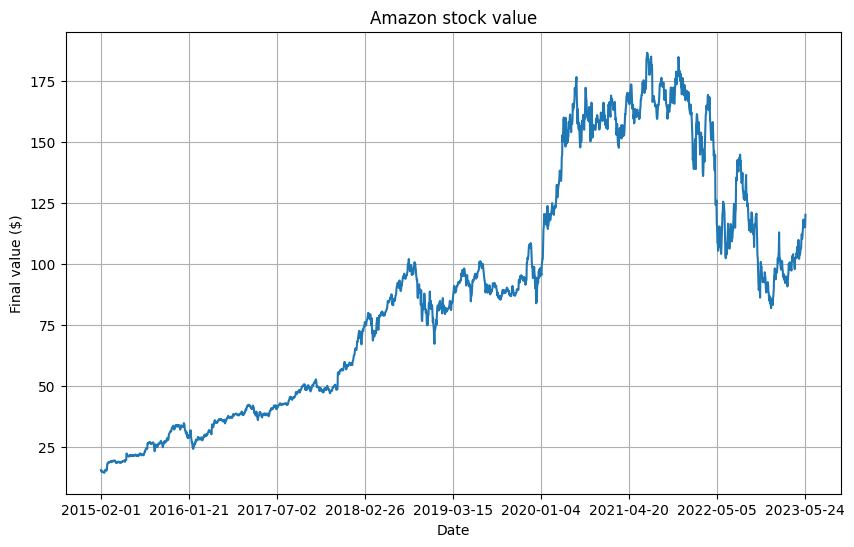

In [ ]:
PATH = 'RNN-Amazon'
path_models='RNN-Amazon/models'
all_models = os.listdir(path_models)
df = pd.read_csv(PATH+'/data/AmazonWeb.csv',sep = ',', parse_dates=['Fecha'], decimal=',')
df

time = df['Fecha'].to_numpy() # dates column
series = df['Último'].to_numpy() # final value of the stock

time_ord = np.flip(time) # Sorting data
series_ord = np.flip(series)

time_ord = time_ord.astype('datetime64[D]')
x_axis = np.arange(len(time_ord))

plot_series(x_axis, series_ord, title='Amazon stock value', xlabel='Date', ylabel='Final value ($)', xticks=time_ord, samples=8)

## Split data and create datasets

In [ ]:
# Define the split time
split_time = int(len(series_ord)*0.9) # 90% of data to train the models

# Get the train set
time_train = time_ord[:split_time]
x_train = series_ord[:split_time]

# Get the validation set
time_valid = time_ord[split_time:]
x_valid = series_ord[split_time:]

batch_size = 16
shuffle_buffer_size = 1000

## Models evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(path_model, model_name, serie, x_valid, window_size, batch_size, step, graph, pred_out=1):

    '''
        Function to evaluate a model.
        Inputs:
        path_models: path to directory from where the model will be load
        model_name: name of the model
        X_test, Y_test: evaluation data
        sc_price: object to transform data
        step: factor of bins for residual histogram

        Outputs:
        mse, mae: mean square error and mean absolute error
    '''

    model_loaded = tf.keras.models.load_model(os.path.join(path_model, model_name))

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(serie)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    forecast = model_loaded.predict(dataset)
    if pred_out > 1:
        x_valid1 = []
        for i in range(len(x_valid)-pred_out+1):
            x_valid1.append(x_valid[i:i+pred_out])

    else:
        x_valid1 = x_valid[:]

    mae = mean_absolute_error(x_valid1, forecast.squeeze())

    #copy of the input lists
    true = x_valid1[:]
    pred = forecast.squeeze()[:]

    #empty list to allocate  residuals
    residual = true-pred

    res_m = np.mean(residual)
    res_var = np.var(residual)

    residual1 = []
    if pred_out > 1:
      # check if arrays have the same dimension
      for cicle in range(len(true)):
        # cicle has the amount of outputs
        for item in range(len(true[cicle])):
          residual1.append(true[cicle][item] - pred[cicle][item])
    else:
       residual1 = residual[:]

    if graph:
        plt.figure(figsize=(10, 10))
        plt.plot(x_valid, 'b', label = 'true values')
        plt.plot(forecast.squeeze(), 'r', label = 'predictions')
        plt.title('Comparision')
        plt.ylabel('Price')
        plt.xlabel('Time')
        plt.show()



        # Plot residual graph to evaluate data distribution
        plt.figure(figsize=(10, 10))
        plt.plot(residual1, 'b', label = 'Residuals')
        plt.title('Residuals graph')
        plt.ylabel('Residual value')
        plt.xlabel('Number of predictions')
        plt.legend(loc = 'upper left')
        plt.show()

        # Min and max to plot the histogram
        minim = np.min(residual1)
        maxim = np.max(residual1)

        # Number of bars in the histogram
        bins = int(abs((maxim - minim) / step))

        #convert to pandas dataframe to use the function hist from that library
        df = pd.DataFrame(residual1, columns = ['Residuals Histogram'])
        hist = df.hist(bins = bins, figsize=(10,10))

    return mae, res_m, res_var

In [ ]:
path_models = PATH+'/models'
## Stage parameters
window_size = 15
pred_out = 1

model_type_list_red = ['MLP', 'RNN', 'LSTM', 'GRU', 'Conv1D']
all_models = os.listdir(path_models)

################################

metrics_151 = []

for arch in model_type_list_red:

    for model in all_models:

        if arch in model:

            options = model.split('_')

            if options[-1] == str(pred_out) + '.h5' and options[-2] == str(window_size):

                metrics_151.append([model, evaluate_model(path_models, model, series_ord[split_time-window_size:-pred_out], x_valid, window_size, batch_size, step=1, graph=False, pred_out=pred_out)])


## Stage parameters
window_size = 30
pred_out = 1
################################

metrics_301 = []

for arch in model_type_list_red:

    for model in all_models:

        if arch in model:

            options = model.split('_')

            if options[-1] == str(pred_out) + '.h5' and options[-2] == str(window_size):

                metrics_301.append([model, evaluate_model(path_models, model, series_ord[split_time-window_size:-pred_out], x_valid, window_size, batch_size, step=1, graph=False, pred_out=pred_out)])


## Stage parameters
window_size = 60
pred_out = 1
################################

metrics_601 = []

for arch in model_type_list_red:

    for model in all_models:

        if arch in model:

            options = model.split('_')

            if options[-1] == str(pred_out) + '.h5' and options[-2] == str(window_size):

                metrics_601.append([model, evaluate_model(path_models, model, series_ord[split_time-window_size:-pred_out], x_valid, window_size, batch_size, step=1, graph=False, pred_out=pred_out)])


14/14 [==============================] - 0s 11ms/step


In [ ]:
## Stage parameters
window_size = 30
pred_out = 7

model_type_list_red = ['MLP', 'RNN', 'LSTM', 'GRU', 'Conv1D']
all_models = os.listdir(path_models)

################################

metrics_307 = []

for arch in model_type_list_red:

    for model in all_models:

        if arch in model:

            options = model.split('_')

            if options[-1] == str(pred_out) + '.h5' and options[-2] == str(window_size):

                metrics_307.append([model, evaluate_model(path_models, model, series_ord[split_time-window_size:-pred_out], x_valid, window_size, batch_size, step=1, graph=False, pred_out=pred_out)])


## Stage parameters
window_size = 60
pred_out = 7
################################

metrics_607 = []

for arch in model_type_list_red:

    for model in all_models:

        if arch in model:

            options = model.split('_')

            if options[-1] == str(pred_out) + '.h5' and options[-2] == str(window_size):

                metrics_607.append([model, evaluate_model(path_models, model, series_ord[split_time-window_size:-pred_out], x_valid, window_size, batch_size, step=1, graph=False, pred_out=pred_out)])


## Stage parameters
window_size = 120
pred_out = 7
################################

metrics_1207 = []

for arch in model_type_list_red:

    for model in all_models:

        if arch in model:

            options = model.split('_')

            if options[-1] == str(pred_out) + '.h5' and options[-2] == str(window_size):

                metrics_1207.append([model, evaluate_model(path_models, model, series_ord[split_time-window_size:-pred_out], x_valid, window_size, batch_size, step=1, graph=False, pred_out=pred_out)])

13/13 [==============================] - 0s 11ms/step


In [ ]:
def comparision_window(target, metrics_pred):
    # Extraer las métricas para el target dado
    target_metrics = [[abs(metric[1][target]) for metric in metric_set] for metric_set in metrics_pred]

    # Extraer los nombres de los modelos
    model_names = [metric[0] for metric in metrics_pred[0]]
    model_names_axis = [''.join(name.split('_')[:-2]) for name in model_names]

    # Configuración del gráfico
    bar_width = 0.2
    r_positions = [np.arange(len(target_metrics[i])) + (i * bar_width) for i in range(len(target_metrics))]

    # Verificar la ventana temporal
    first_model_window = metrics_pred[0][0][0]
    temporal_windows = ['15', '30', '60'] if '15' in first_model_window else ['30', '60', '120']



   # Configuración del gráfico con tamaño más pequeño (10 de ancho y 4 de alto)
    plt.figure(figsize=(10, 4))  # Modificar el tamaño aquí
    colors = ['blue', 'green', 'red']  # Cambiados a azul, verde y rojo
    for i, r in enumerate(r_positions):
        plt.bar(r, target_metrics[i], width=bar_width, label=f'{temporal_windows[i]} días', color=colors[i], edgecolor='black', linewidth=1)

    # Calcular y mostrar las líneas de la media
    means = [np.mean([target_metrics[j][i] for j in range(len(target_metrics))]) for i in range(len(target_metrics[0]))]
    for i, mean in enumerate(means):
        plt.hlines(mean, r_positions[0][i], r_positions[-1][i], colors='black', linestyles='dashed')

    # Configuración final del gráfico
    plt.xticks([r + (bar_width * len(target_metrics) / 2) for r in r_positions[0]], model_names_axis, fontsize=12, rotation=60)
    plt.title(['Mean Absolute Error', 'Module of the Mean of the Residuals', 'Module of the Variance of the Residuals'][target])
    plt.legend()
    plt.grid(True)
    plt.show()

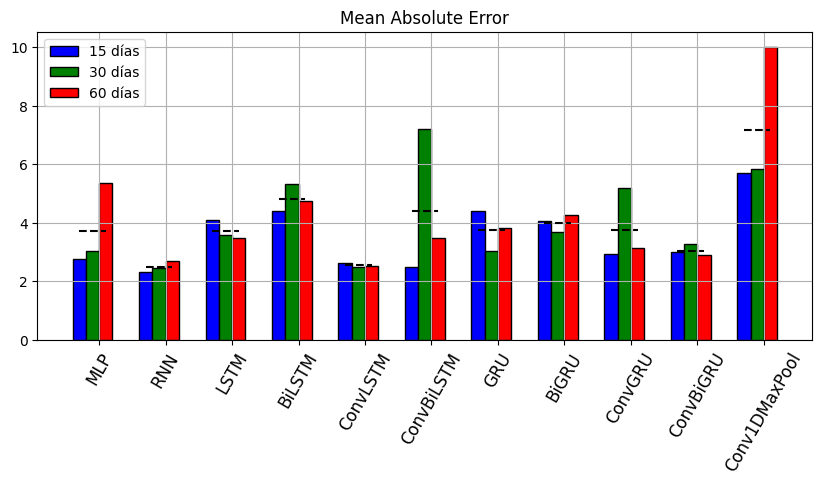

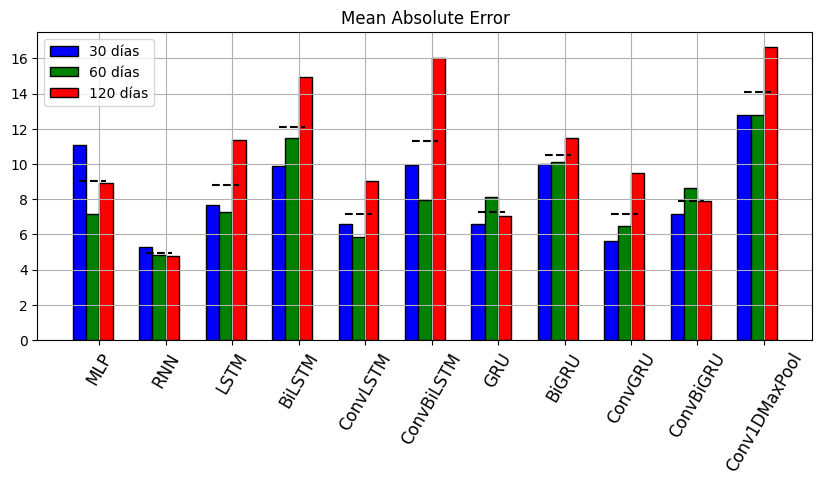

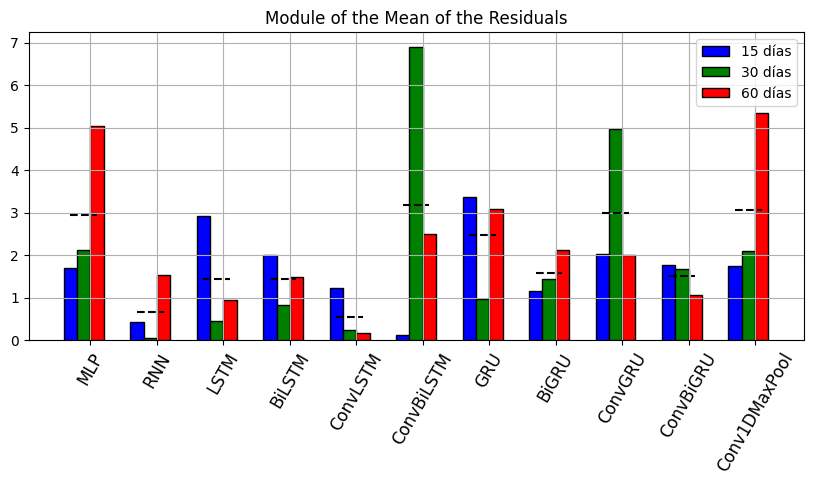

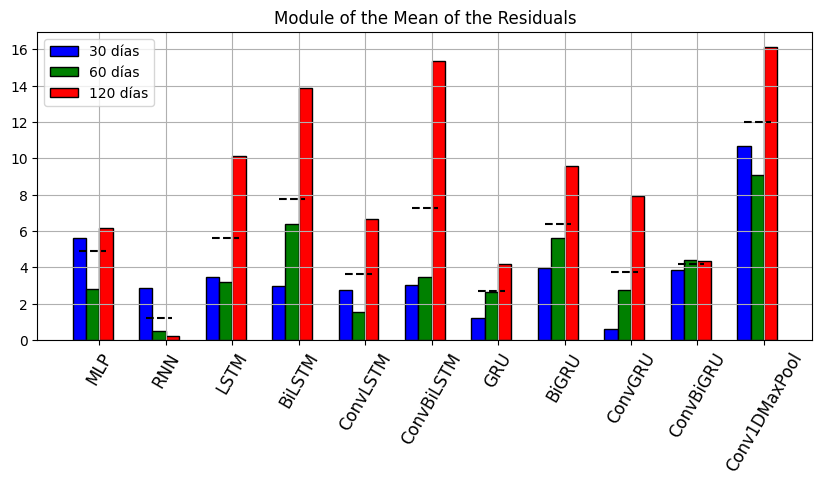

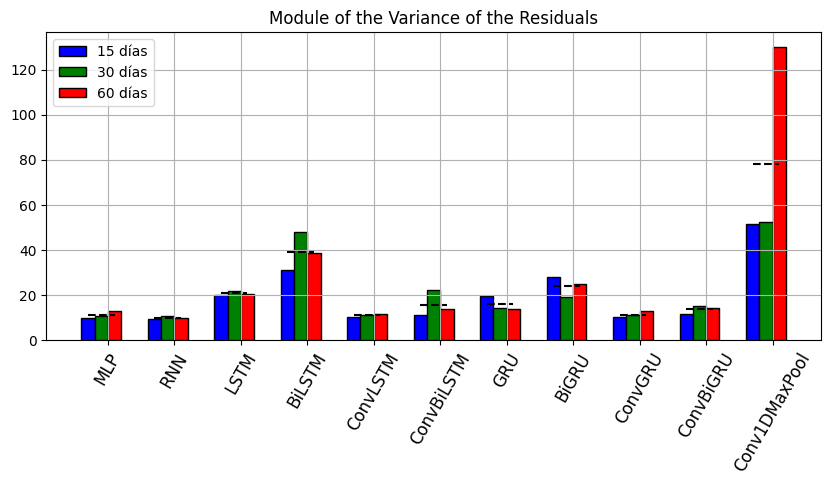

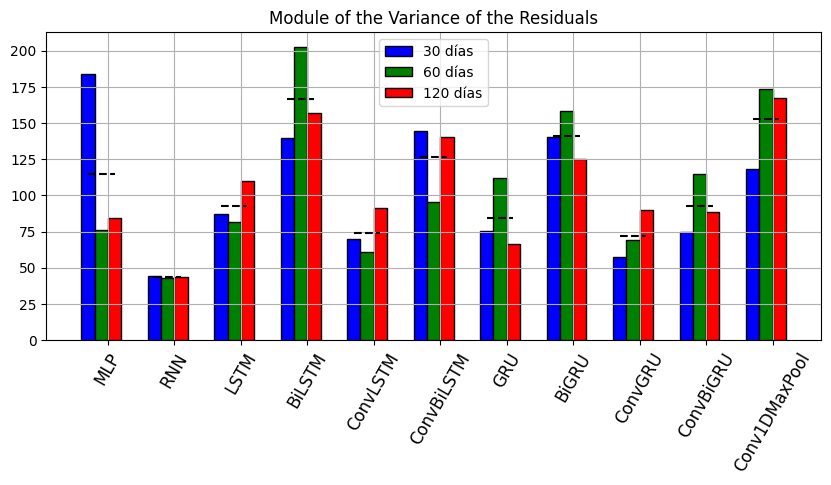

In [ ]:
'''
target = 0 -> MAE
target = 1 -> mean of residuals (absolute)
target = 2 -> var of residuals (absolute)
'''

comparision_window(target=0, metrics_pred=[metrics_151, metrics_301, metrics_601])
comparision_window(target=0, metrics_pred=[metrics_307, metrics_607, metrics_1207])

comparision_window(target=1, metrics_pred=[metrics_151, metrics_301, metrics_601])
comparision_window(target=1, metrics_pred=[metrics_307, metrics_607, metrics_1207])

comparision_window(target=2, metrics_pred=[metrics_151, metrics_301, metrics_601])
comparision_window(target=2, metrics_pred=[metrics_307, metrics_607, metrics_1207])